# EMNIST Image Classification

## Test Cuda

In [1]:
import torch

In [2]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1060 6GB'

In [3]:
torch.cuda.device_count()

1

## Start MLFlow

In [4]:
get_ipython().system_raw("mlflow ui --port 5000 --host 0.0.0.0 &")

[2024-02-25 09:36:12 +0000] [114] [INFO] Starting gunicorn 21.2.0
[2024-02-25 09:36:12 +0000] [114] [INFO] Listening at: http://0.0.0.0:5000 (114)
[2024-02-25 09:36:12 +0000] [114] [INFO] Using worker: sync
[2024-02-25 09:36:12 +0000] [115] [INFO] Booting worker with pid: 115
[2024-02-25 09:36:12 +0000] [116] [INFO] Booting worker with pid: 116
[2024-02-25 09:36:12 +0000] [117] [INFO] Booting worker with pid: 117
[2024-02-25 09:36:12 +0000] [118] [INFO] Booting worker with pid: 118


In [5]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional import accuracy

In [6]:
BATCH_SIZE = 64
INPUT_SIZE = 28*28
OUTPUT_SIZE = 26

## Dataset

In [7]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
len(classes)

26

In [8]:
emnist_train_data = pd.read_csv("./datasets/emnist-letters-train.csv", header=None)

emnist_test_data = pd.read_csv("./datasets/emnist-letters-test.csv", header=None)
emnist_test_data = emnist_test_data.sample(frac=1)

In [9]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe):
        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype=torch.float32)
        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.images[idx]
        images = images / 255.0
        labels = self.labels[idx]

        return images, labels

In [10]:
train_ds = EMNISTDataset(emnist_train_data)
test_ds = EMNISTDataset(emnist_test_data)

### Train/Test Split

In [11]:
val_percent = 0.1
val_len = int(val_percent * len(train_ds))

train, val = random_split(train_ds, [len(train_ds) - val_len, val_len])
print(len(train), len(val))

79920 8880


### Dataloaders

In [12]:
train_dl = DataLoader(train, BATCH_SIZE, shuffle=True, drop_last=True, num_workers=1)
val_dl = DataLoader(val, BATCH_SIZE, num_workers=1)
test_dl = DataLoader(test_ds, BATCH_SIZE, num_workers=1)

print(len(train_dl), len(val_dl), len(test_dl))

1248 139 232


## Model Training

### Create the MLFlow Experiment

In [14]:
experiment_name = "emnist_classifier_cnn"
mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///opt/app/notebooks/mlruns/262837661499144889', creation_time=1708863660151, experiment_id='262837661499144889', last_update_time=1708863660151, lifecycle_stage='active', name='emnist_classifier_cnn', tags={}>

In [15]:
dataset_info = """
The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19  and converted to a 28x28 pixel
image format and dataset structure that directly matches the MNIST dataset . Further information on the dataset contents and conversion
process can be found in the paper available at https://arxiv.org/abs/1702.05373v1
"""

with open("dataset_info.txt", "w") as f:
    f.write(dataset_info)

In [16]:
with mlflow.start_run(run_name = 'emnist_classifier_cnn_test_run') as current_run:
    mlflow.log_metric('Accuracy', 0.67)

    params = {
        'num_nn_layers': 4
    }
    
    mlflow.log_params(params)
    mlflow.log_artifact('dataset_info.txt')
    mlflow.set_tag('EMNIST', 'Character Classification')

### Lightning Model Training

In [17]:
class EmnistModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64*14*14

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 256*7*7

            nn.Flatten(),
            nn.Linear(256*7*7, 32),
            nn.ReLU(),

            nn.Linear(32,64),
            nn.ReLU(),

            nn.Linear(64,26)            
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1,1,28,28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

    def training_step(self, batch, batch_idx):
        # batches consists of images and labels
        x, y = batch
        # labels start at 1 but the classes at 0
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def predict_step(self, batch, batch_idx, dataloaders_idx=0):
        x, y = batch
        
        return self(x)

In [18]:
emnist_model = EmnistModel()
logger = CSVLogger("logs", name="emnist_classifier_cnn")
trainer = pl.Trainer(max_epochs = 10, logger=logger)
mlflow.pytorch.autolog(log_models = False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2024/02/25 12:21:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


In [19]:
with mlflow.start_run() as run:
    trainer.fit(emnist_model, train_dl, val_dl)
    trainer.test(dataloaders = test_dl)

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(emnist_model, "emnist_classifier_cnn", signature = signature)

# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#        Test metric             DataLoader 0
# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
#         test_acc            0.9125000238418579
#         test_loss           0.2667196989059448
# ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

2024/02/25 12:21:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/mlflow/pytorch/_lightning_autolog.py:356: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.4.9 and 2.1.3 and may not succeed with packages outside this range."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 793 K 
-----------------------------------------------
793 K     Trainable params
0         Non-trainable params
793 K     Total params
3.172     Total estimated model params size (MB)


Sanity Checking: |                                                                            | 0/? [00:00<?, …

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                   | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

Validation: |                                                                                 | 0/? [00:00<?, …

`Trainer.fit` stopped: `max_epochs=10` reached.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/emnist_classifier_cnn/version_1/checkpoints/epoch=9-step=12480.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/emnist_classifier_cnn/version_1/checkpoints/epoch=9-step=12480.ckpt
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performan

Testing: |                                                                                    | 0/? [00:00<?, …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9129053950309753
        test_loss           0.26796019077301025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Model Evaluation

In [20]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
0,0,49,NaN,NaN,NaN,0.015625,NaN,3.198509,NaN,NaN
1,0,99,NaN,NaN,NaN,0.250000,NaN,2.503046,NaN,NaN
2,0,149,NaN,NaN,NaN,0.343750,NaN,2.261891,NaN,NaN
3,0,199,NaN,NaN,NaN,0.437500,NaN,1.935774,NaN,NaN
4,0,249,NaN,NaN,NaN,0.562500,NaN,1.445356,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
265,9,12399,NaN,NaN,NaN,0.984375,NaN,0.049937,NaN,NaN
266,9,12449,NaN,NaN,NaN,0.984375,NaN,0.049309,NaN,NaN
267,9,12479,NaN,NaN,NaN,NaN,NaN,NaN,0.921059,0.241782
268,9,12479,NaN,NaN,0.945037,NaN,0.157439,NaN,NaN,NaN


<Axes: xlabel='epoch'>

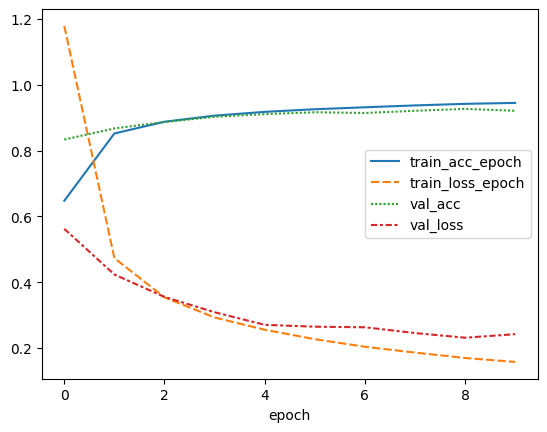

In [21]:
metrics.set_index("epoch", inplace=True)
metrics.drop(columns=['step', 'train_loss_step',
                      'train_acc_step', 'test_acc', 'test_loss'], inplace=True)
sns.lineplot(data=metrics)

### ModelPredictions

In [22]:
run_id = mlflow.last_active_run().info.run_id

In [23]:
# get a test batch of images
test_dataiter = iter(test_dl)
test_images, test_labels = next(test_dataiter)
test_images.shape, test_labels.shape

(torch.Size([64, 784]), torch.Size([64]))

In [24]:
model_path = f"runs:/{run_id}/emnist_classifier_cnn"
loaded_model = mlflow.pyfunc.load_model(model_path)

In [25]:
predictions = loaded_model.predict(test_images.numpy().reshape(-1,1,28,28))
predictions[:1]
# returns prediction probabilities for all 26 classes for the first image

array([[  0.7036465 ,  -3.6041906 ,  15.569413  ,   0.67305547,
          7.6369677 ,   1.6244689 ,   3.34759   , -14.271512  ,
          0.14943919,  -6.773014  ,  -1.957026  ,   2.0267766 ,
        -14.0605545 ,  -6.9126453 ,   4.0077786 ,   2.041849  ,
          2.522574  ,   4.68117   ,  -4.1803956 ,   1.8880728 ,
         -0.7573013 ,  -2.3524656 , -12.300403  , -14.040083  ,
          0.19723892, -10.495769  ]], dtype=float32)

In [26]:
# reshape image to the original 28x28 shape
test_images_reshaped = test_images.reshape(-1, 28, 28)
test_samples = np.random.randint(0, len(test_images), 16)
test_samples

array([14, 32, 58,  7, 33, 54, 45, 17,  8, 19, 58, 62, 56, 17, 49, 10])

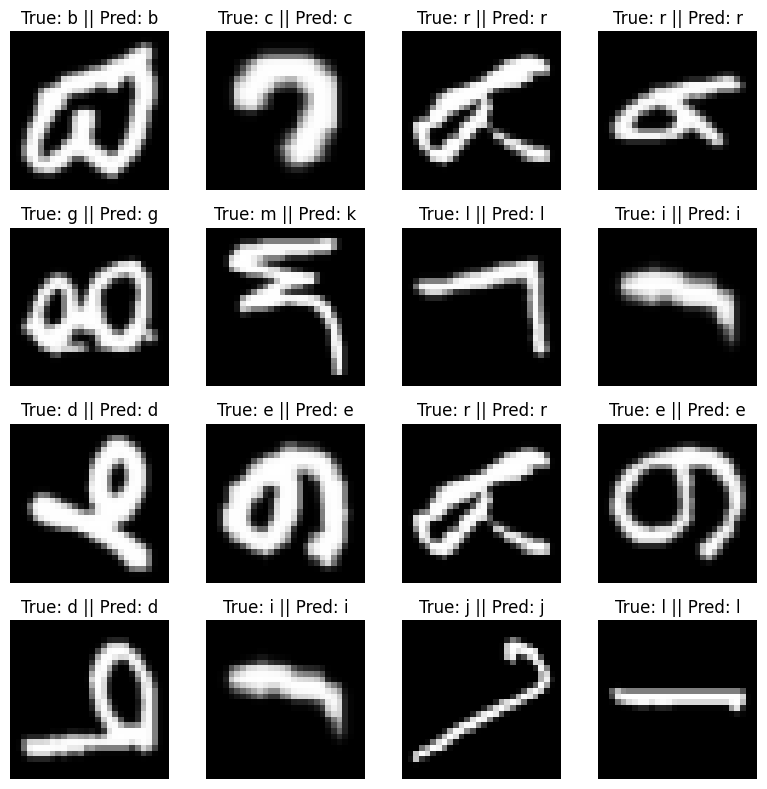

In [27]:
fig = plt.figure(figsize = (8, 8))

for i, idx in enumerate(test_samples):
    true_label = classes[int(test_labels[idx].item()) - 1]
    pred_label = classes[np.argmax(predictions[idx])]
    
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images_reshaped[idx] / 255.0, cmap="gray")
    plt.title(f"True: {true_label} || Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Confusion

In [28]:
y_pred = []
y_true = []

In [29]:
for inputs, labels in test_dl:
    output = loaded_model.predict(inputs.numpy().reshape(-1,1,28,28))

    output = np.argmax(output, axis=1).astype('float64').tolist()
    y_pred.extend(output)

    labels = [x-1 for x in labels.tolist()]
    y_true.extend(labels)

In [30]:
acc = accuracy_score(y_true, y_pred)
acc

0.9129054054054054

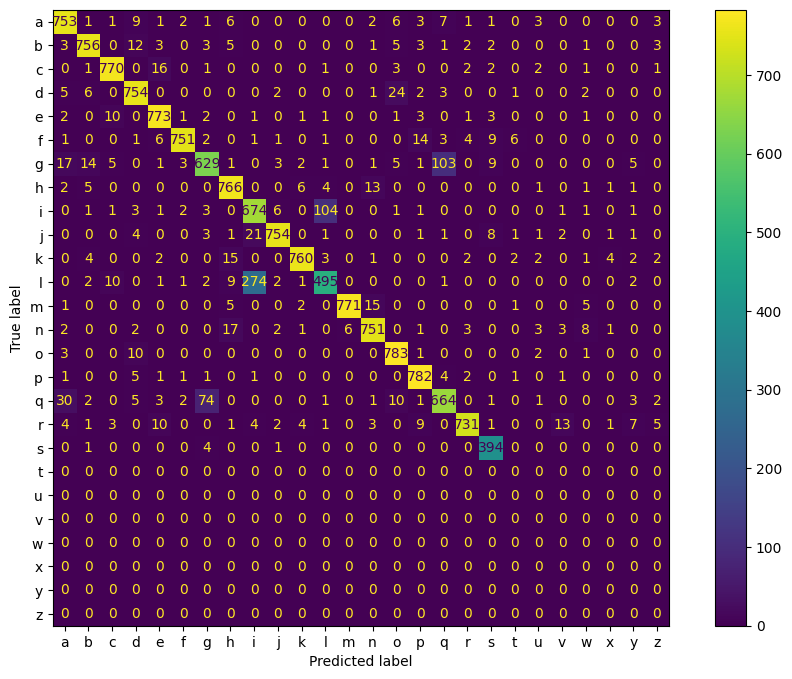

In [31]:
cm = confusion_matrix(y_true, y_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=classes)

fig, ax = plt.subplots(figsize = (12,8))
confusion.plot(ax = ax)

## Hyperopt - Hyper-parameter Optimization

In [32]:
!pip install hyperopt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 696.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 2.1 MB/s eta 0:00:00 0:00:01


In [63]:
import hyperopt
from hyperopt import fmin, tpe, hp, Trials

In [34]:
# optimization for the learning rate and number of neurons in linear layers
search_space = {
    "lr": hp.loguniform("lr", -10, -8),
    "l1": hp.choice("l1", [32, 64, 128]),
    "l2": hp.choice("l2", [64, 128, 256])
}

### Adding HParams to Lightning Model

In [51]:
class EmnistModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)
        
        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64*14*14

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 256*7*7

            nn.Flatten(),
            nn.Linear(256*7*7, self.hparams["l1"]),
            nn.ReLU(),

            nn.Linear(self.hparams["l1"], self.hparams["l2"]),
            nn.ReLU(),

            nn.Linear(self.hparams["l2"], 26)            
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1,1,28,28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = self.hparams["lr"])

    def training_step(self, batch, batch_idx):
        # batches consists of images and labels
        x, y = batch
        # labels start at 1 but the classes at 0
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim=1)

        acc = accuracy(pred, y, task="multiclass", num_classes=26)
        
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

        return acc

    def predict_step(self, batch, batch_idx, dataloaders_idx=0):
        x, y = batch
        
        return self(x)

### Run Optimization with MLFlow Logging

In [55]:
def train_emnist(params):
    # create a group of mlflow runs that nests all experiments
    with mlflow.start_run(nested=True):
        model = EmnistModel(params)

        trainer = pl.Trainer(max_epochs=10, accelerator="gpu")
        trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

        train_loss = trainer.callback_metrics["train_loss"].item()
        train_acc = trainer.callback_metrics["train_acc"].item()
        valid_loss = trainer.callback_metrics["val_loss"].item()
        valid_acc = trainer.callback_metrics["val_acc"].item()

        mlflow.log_params(params)

        mlflow.log_metrics({
            "train_loss_avg": train_loss, "train_acc_avg": train_acc,
            "val_loss_avg": valid_loss, "val_loss_avg": valid_acc
        })

        input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
        output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        mlflow.pytorch.log_model(model, "emnist_classifier_hyper__cnn", signature=signature)

        return -valid_acc # run optimization to minimize negative validation accuracy

In [56]:
with mlflow.start_run():
    best_result = fmin(
        fn=train_emnist,
        space=search_space,
        algo=tpe.suggest,
        max_evals=10
    )

  0%|                                                                        | 0/10 [00:00<?, ?trial/s, best loss=?]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 793 K 
-----------------------------------------------
793 K     Trainable params
0         Non-trainable params
793 K     Total params
3.172     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 10%|████▍                                       | 1/10 [04:01<36:13, 241.48s/trial, best loss: -0.9302927851676941]

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | net

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 20%|████████▊                                   | 2/10 [08:05<32:24, 243.08s/trial, best loss: -0.9302927851676941]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 2.0 M 
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.133     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 30%|█████████████▏                              | 3/10 [12:13<28:36, 245.28s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 2.0 M 
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 40%|█████████████████▌                          | 4/10 [16:23<24:43, 247.17s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 804 K 
-----------------------------------------------
804 K     Trainable params
0         Non-trainable params
804 K     Total params
3.218     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 50%|██████████████████████                      | 5/10 [20:14<20:07, 241.45s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 2.0 M 
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.054     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 60%|██████████████████████████▍                 | 6/10 [24:33<16:29, 247.36s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 1.2 M 
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.786     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 70%|██████████████████████████████▊             | 7/10 [28:52<12:33, 251.09s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 1.2 M 
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.786     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 80%|███████████████████████████████████▏        | 8/10 [32:53<08:15, 247.75s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 1.2 M 
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.786     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


 90%|███████████████████████████████████████▌    | 9/10 [36:48<04:03, 243.90s/trial, best loss: -0.9336711764335632]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | network   | Sequential       | 1.2 M 
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.786     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


100%|███████████████████████████████████████████| 10/10 [41:06<00:00, 246.61s/trial, best loss: -0.9336711764335632]


In [61]:
print("Best Results:")
print('l1: ', [32, 64, 128][best_result['l1']])
print('l1: ', [64, 128, 256][best_result['l1']])
print('lr: ', best_result['lr'])

Best Results:
l1:  128
l1:  256
lr:  0.00013761616014749492


In [64]:
print(hyperopt.space_eval(search_space, best_result))

{'l1': 128, 'l2': 256, 'lr': 0.00013761616014749492}


### Run Predictions with Best Model

In [93]:
# get run ID for the above model from the MLFlow dashboard
logged_model = 'runs:/80f82f97d942473aab55f5ba47df8db2/emnist_classifier_hyper__cnn'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(test_images.numpy().reshape(-1,1,28,28))

print("Predicted Class:", classes[np.argmax(predictions[0])])

Predicted Class: c


In [94]:
print("True Class:", classes[int(test_labels[0].item()) - 1])

True Class: c


In [95]:
test_samples = np.random.randint(0, len(test_images), 16)

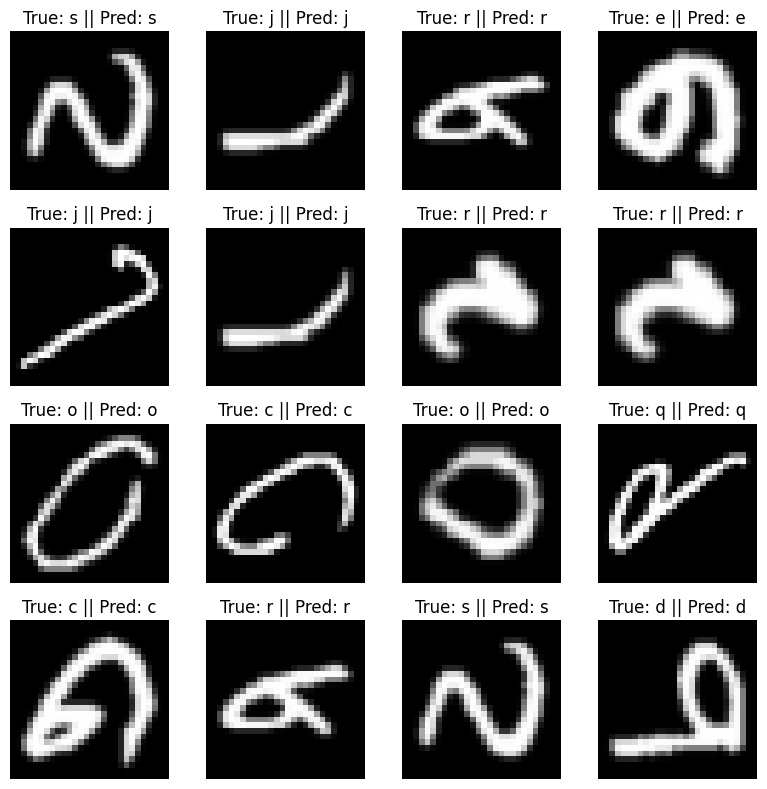

In [100]:
fig = plt.figure(figsize = (8, 8))

for i, idx in enumerate(test_samples):
    true_label = classes[int(test_labels[idx].item()) - 1]
    pred_label = classes[np.argmax(predictions[idx])]
    
    plt.subplot(4, 4, i+1)
    plt.imshow(test_images[idx].numpy().reshape(-1,1,28,28).squeeze() / 255.0, cmap="gray")
    plt.title(f"True: {true_label} || Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [86]:
y_pred = []
y_true = []

In [88]:
for inputs, labels in test_dl:
    output = loaded_model.predict(inputs.numpy().reshape(-1,1,28,28))

    output = np.argmax(output, axis=1).astype('float64').tolist()
    y_pred.extend(output)

    labels = [x-1 for x in labels.tolist()]
    y_true.extend(labels)

In [89]:
acc = accuracy_score(y_true, y_pred)
acc

0.9215540540540541

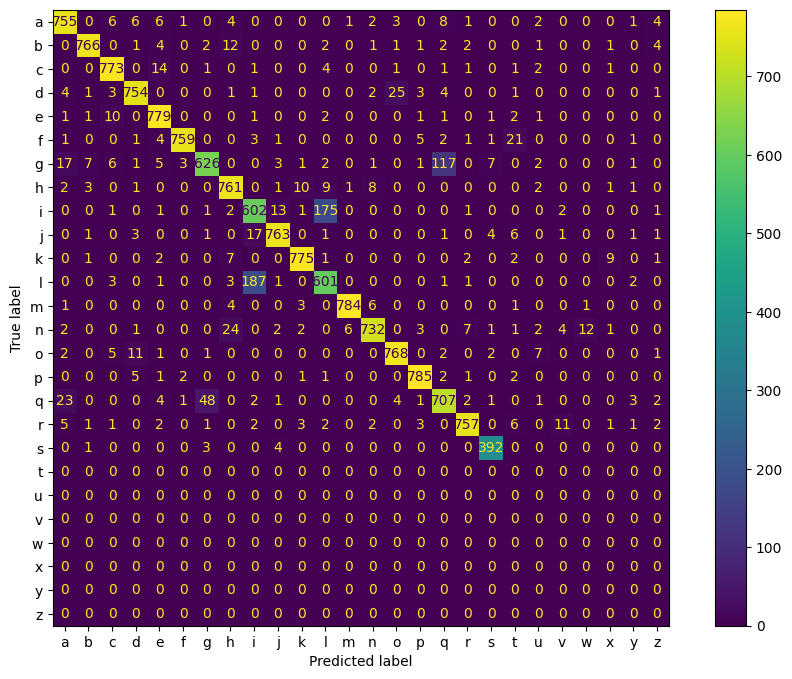

In [90]:
cm = confusion_matrix(y_true, y_pred)
confusion = ConfusionMatrixDisplay(cm, display_labels=classes)

fig, ax = plt.subplots(figsize = (12,8))
confusion.plot(ax = ax)